In [1]:
import zipfile
import io
import datetime
import sys

import numpy as np
import requests
import pandas as pd
import statsmodels.api as sm

sys.path.append('../../..')
from lib import psmsl, models

# Sea-level acceleration in tide gauge records
This notebook gives a rough estimate on the sea-level acceleration in tide gauges. Tide gauges, especially long running tide gauges, are mainly located in cities with ports in the Northern Hemisphere. The acceleration in these locations will be different from the global mean sea-level acceleration. 


Get the data from the PSMSL. This is a zip file with all the annual means. 

In [2]:
resp = requests.get('http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip')

In [3]:
stream = io.BytesIO(resp.content)
zf = zipfile.ZipFile(stream)

In [4]:
stations = pd.read_csv(
    io.BytesIO(zf.read('rlr_annual/filelist.txt')),  
    sep=';', 
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')


This stations variable now contains a list of all the stations. Now we have to extract all the timeseries.

In [5]:
measurements = []
for i, station in stations.iterrows():
    df = psmsl.get_data(zf, station, 'rlr_annual')
    measurements.append(df)
measurements = pd.concat(measurements)

Now we add some metadata. Number of records and temporal coverage

In [6]:
records = []
for i, df in measurements.groupby('station'):
    n_records = df.shape[0]
    t_min = df.index.min()
    t_max = df.index.max()
    records.append({
        "station": i,
        "n_records": n_records,
        "t_min": t_min,
        "t_max": t_max
    })
coverage = pd.DataFrame(records)

Now we can filter stations based on coverage (> 50 years and latest measurements after 2010)


In [51]:
selection = coverage[np.logical_and(coverage.n_records > 50, coverage.t_max > datetime.datetime(2010, 1, 1))]
selection = selection.set_index('station')
selection = pd.merge(stations, selection, left_index=True, right_index=True)

In [52]:
# number of selected stations
selection

,lat,lon,name,coastline_code,station_code,quality,n_records,t_min,t_max
1,48.382850,-4.494838,BREST,190,91,N,213,1807-01-01,2019-01-01
5,53.313944,-4.620444,HOLYHEAD,170,191,Y,82,1938-01-01,2019-01-01
7,53.866667,8.716667,CUXHAVEN 2,140,12,N,176,1843-01-01,2018-01-01
8,53.898889,11.458056,WISMAR 2,120,22,N,170,1849-01-01,2018-01-01
9,51.917500,4.249722,MAASSLUIS,150,61,N,172,1848-01-01,2019-01-01
...,...,...,...,...,...,...,...,...,...
2105,57.639167,18.284444,VISBY,50,96,N,104,1916-01-01,2019-01-01
2106,57.275000,16.478056,OSKARSHAMN,50,85,N,59,1961-01-01,2019-01-01
2109,55.756389,12.903333,BARSEBACK,50,64,N,83,1937-01-01,2019-01-01
2111,57.249722,12.112500,RINGHALS,50,35,N,52,1968-01-01,2019-01-01


Now combine the metadata with the timeseries, so everything is in one dataframe.

In [53]:
merged = pd.merge(measurements, selection, left_on='station', right_index=True)
merged.head()


,year,height,interpolated,flags,station,lat,lon,name,coastline_code,station_code,quality,n_records,t_min,t_max
t,,,,,,,,,,,,,,
1807-01-01,1807.0,6970.0,N,10,1,48.38285,-4.494838,BREST,190,91,N,213,1807-01-01,2019-01-01
1808-01-01,1808.0,6868.0,N,10,1,48.38285,-4.494838,BREST,190,91,N,213,1807-01-01,2019-01-01
1809-01-01,1809.0,6954.0,N,10,1,48.38285,-4.494838,BREST,190,91,N,213,1807-01-01,2019-01-01
1810-01-01,1810.0,6947.0,N,10,1,48.38285,-4.494838,BREST,190,91,N,213,1807-01-01,2019-01-01
1811-01-01,1811.0,6976.0,N,10,1,48.38285,-4.494838,BREST,190,91,N,213,1807-01-01,2019-01-01


Now for each station, filter by year and apply the linear model to compute the acceleration.

In [54]:
fits = []
for i, df in merged.groupby('station'):
    fit, names = models.linear_acceleration_model(df[df.year > 1890])
    record = {
        'fit': fit,
        'names': names,
        'station': i
    }
    fits.append(record)
fits = pd.DataFrame(fits)
fits = fits.set_index('station')

In [55]:
result = pd.merge(selection, fits, left_index=True, right_index=True)

In [56]:
acceleration = result['fit'].apply(lambda fit: fit.params.x2)
result['acceleration'] = acceleration

Sort by acceleration  (higher acceleration)


In [65]:
result.sort_values('acceleration', ascending=False)[['name', 'coastline_code', 'acceleration']].head(n=5)
    

,name,coastline_code,acceleration
131,AYUKAWA,642,0.419296
1060,MIYAKE SIMA,642,0.313212
409,POSIDHONIA,290,0.208085
1234,SIROS,290,0.172184
1232,SOUDHAS,290,0.170070


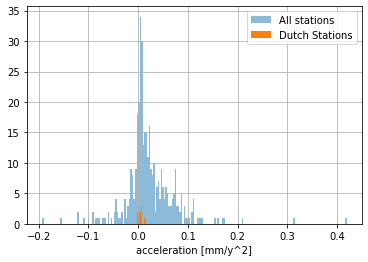

In [78]:
ax = result['acceleration'].hist(bins=200, alpha=0.5, label='All stations')
ax.set_xlabel('acceleration [mm/y^2]')
nl_acceleration = result.query('coastline_code == 150')['acceleration']
result.query('coastline_code == 150')['acceleration'].hist(bins=5, ax=ax, label='Dutch Stations')
ax.legend(loc='best')
